# SegNet

This is a implementation of http://arxiv.org/pdf/1511.00561v2.pdf (Except for the Upsampling layer where paper uses indices based upsampling which is not implemented in keras yet( *I am working on it*), but that shouldnt make a lot of difference)


### Setting Theano Flags

In [1]:
import os
os.environ['KERAS_BACKEND'] = 'theano'
os.environ['THEANO_FLAGS']='mode=FAST_RUN,device=gpu0,floatX=float32,optimizer=fast_compile'

In [2]:

from __future__ import absolute_import
from __future__ import print_function
import pylab as pl
import matplotlib.cm as cm
import itertools
import numpy as np
import theano.tensor as T
np.random.seed(1337) # for reproducibility

from keras.datasets import mnist
import keras.layers.containers as containers
from keras.layers.noise import GaussianNoise
import keras.models as models
import keras.layers.containers as containers
from keras.layers.core import Layer, Dense, Dropout, Activation, Flatten, Reshape, AutoEncoder, Merge, Permute
from keras.layers.convolutional import Convolution2D, MaxPooling2D, UpSampling2D, ZeroPadding2D
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from keras.regularizers import ActivityRegularizer

from keras import backend as K

import cv2
import numpy as np

path = './CamVid/'
data_shape = 360*480

Using gpu device 0: Tesla K80 (CNMeM is disabled, CuDNN 3007)
Using Theano backend.
/home/preddy5/anaconda2/lib/python2.7/site-packages/theano/tensor/signal/downsample.py:5: UserWarning: downsample module has been moved to the pool module.
  warnings.warn("downsample module has been moved to the pool module.")


## Data Fetching 
I equalized histograms of rbg layers separately, so that change in lighting doesnt effect the results.

In [3]:
def normalized(rgb):
    #return rgb/255.0
    norm=np.zeros((rgb.shape[0], rgb.shape[1], 3),np.float32)

    b=rgb[:,:,0]
    g=rgb[:,:,1]
    r=rgb[:,:,2]

    norm[:,:,0]=cv2.equalizeHist(b)
    norm[:,:,1]=cv2.equalizeHist(g)
    norm[:,:,2]=cv2.equalizeHist(r)

    return norm

def binarylab(labels):
    x = np.zeros([360,480,12])    
    for i in range(360):
        for j in range(480):
            x[i,j,labels[i][j]]=1
    return x

def prep_data():
    train_data = []
    train_label = []
    import os
    with open(path+'train.txt') as f:
        txt = f.readlines()
        txt = [line.split(' ') for line in txt]
    for i in range(len(txt)):
        ## these paths are very specific to my machine
        train_data.append(np.rollaxis(normalized(cv2.imread(os.getcwd() + txt[i][0][7:])),2))
        train_label.append(binarylab(cv2.imread(os.getcwd() + txt[i][1][7:][:-1])[:,:,0]))
        print('.',end='')
    return np.array(train_data), np.array(train_label)

train_data, train_label = prep_data()
train_label = np.reshape(train_label,(367,data_shape,12))

...............................................................................................................................................................................................................................................................................................................................................................................

In [4]:

# class weigths
class_weighting= [0.2595, 0.1826, 4.5640, 0.1417, 0.9051, 0.3826, 9.6446, 1.8418, 6.6823, 6.2478, 3.0, 7.3614]


I am using custom Unpooling layer look here https://github.com/fchollet/keras/issues/1226 for the reason

In [5]:
class UnPooling2D(Layer):
    """A 2D Repeat layer"""
    def __init__(self, poolsize=(2, 2)):
        super(UnPooling2D, self).__init__()
        self.input = T.tensor4()
        self.poolsize = poolsize

    @property
    def output_shape(self):
        input_shape = self.input_shape
        return (input_shape[0], input_shape[1],
                self.poolsize[0] * input_shape[2],
                self.poolsize[1] * input_shape[3])

    def get_output(self, train):
        X = self.get_input(train)
        s1 = self.poolsize[0]
        s2 = self.poolsize[1]
        output = X.repeat(s1, axis=2).repeat(s2, axis=3)
        return output

    def get_config(self):
        return {"name":self.__class__.__name__,
            "poolsize":self.poolsize}
    

### Creating and Compiling neuralnet

In [6]:
def create_encoding_layers():
    kernel = 3
    filter_size = 64
    pad = 1
    pool_size = 2
    return [
        ZeroPadding2D(padding=(pad,pad)),
        Convolution2D(filter_size, kernel, kernel, border_mode='valid'),
        BatchNormalization(),
        Activation('relu'),
        MaxPooling2D(pool_size=(pool_size, pool_size)),

        ZeroPadding2D(padding=(pad,pad)),
        Convolution2D(128, kernel, kernel, border_mode='valid'),
        BatchNormalization(),
        Activation('relu'),
        MaxPooling2D(pool_size=(pool_size, pool_size)),

        ZeroPadding2D(padding=(pad,pad)),
        Convolution2D(256, kernel, kernel, border_mode='valid'),
        BatchNormalization(),
        Activation('relu'),
        MaxPooling2D(pool_size=(pool_size, pool_size)),

        ZeroPadding2D(padding=(pad,pad)),
        Convolution2D(512, kernel, kernel, border_mode='valid'),
        BatchNormalization(),
        Activation('relu'),
    ]

def create_decoding_layers():
    kernel = 3
    filter_size = 64
    pad = 1
    pool_size = 2
    return[
        ZeroPadding2D(padding=(pad,pad)),
        Convolution2D(512, kernel, kernel, border_mode='valid'),
        BatchNormalization(),

        UnPooling2D(poolsize=(pool_size,pool_size)),
        ZeroPadding2D(padding=(pad,pad)),
        Convolution2D(256, kernel, kernel, border_mode='valid'),
        BatchNormalization(),

        UnPooling2D(poolsize=(pool_size,pool_size)),
        ZeroPadding2D(padding=(pad,pad)),
        Convolution2D(128, kernel, kernel, border_mode='valid'),
        BatchNormalization(),

        UnPooling2D(poolsize=(pool_size,pool_size)),
        ZeroPadding2D(padding=(pad,pad)),
        Convolution2D(filter_size, kernel, kernel, border_mode='valid'),
        BatchNormalization(),
    ]

autoencoder = models.Sequential()
# Add a noise layer to get a denoising autoencoder. This helps avoid overfitting
autoencoder.add(Layer(input_shape=(3, 360, 480)))

#autoencoder.add(GaussianNoise(sigma=0.3))
autoencoder.encoding_layers = create_encoding_layers()
autoencoder.decoding_layers = create_decoding_layers()
for l in autoencoder.encoding_layers:
    autoencoder.add(l)
for l in autoencoder.decoding_layers:
    autoencoder.add(l)

autoencoder.add(Convolution2D(12, 1, 1, border_mode='valid',))
autoencoder.add(Reshape((12,data_shape)))
autoencoder.add(Permute((2, 1)))
autoencoder.add(Activation('softmax'))
#from keras.optimizers import SGD
#optimizer = SGD(lr=0.01, momentum=0.8, decay=0., nesterov=False)
autoencoder.compile(loss="categorical_crossentropy", optimizer='adadelta')

Visualizing autoencoder

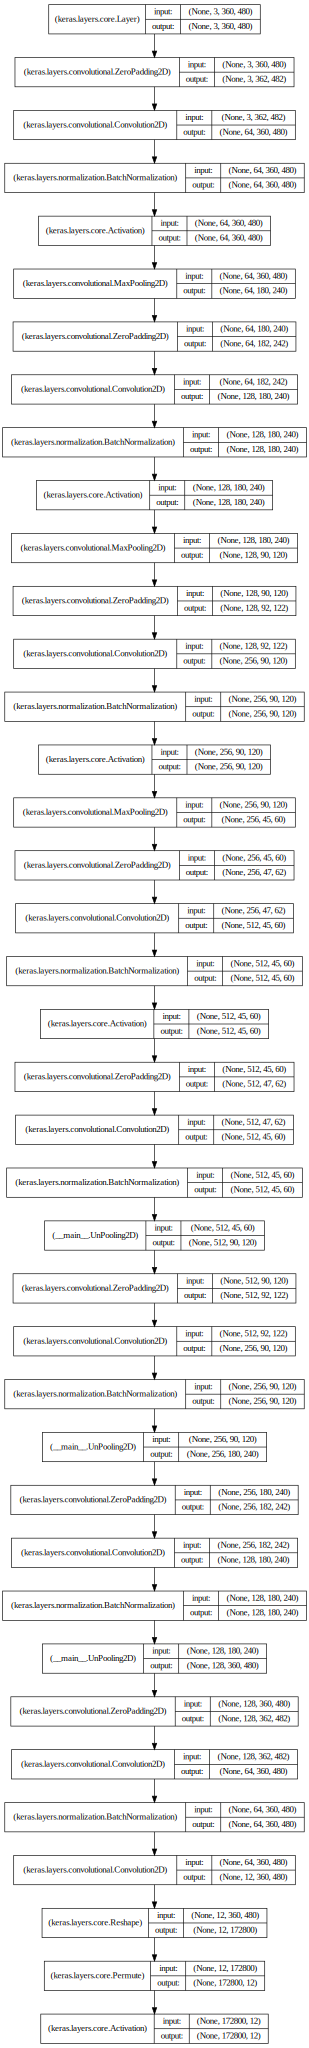

In [10]:
import keras.utils.visualize_util as vutil
from IPython.display import SVG

SVG(vutil.to_graph(autoencoder, recursive=True, show_shape=True).create(prog='dot', format="svg"))


## Training 
At the end of 100 epochs training acc was about 0.91

#### Epoch 100/100

367/367 [==============================] - 890s - loss: 0.2942 - acc: 0.9100   


In [ ]:
nb_epoch = 5
batch_size = 10

history = autoencoder.fit(train_data, train_label, batch_size=batch_size, nb_epoch=nb_epoch,
                    show_accuracy=True, verbose=1, class_weight=class_weighting )#, validation_data=(X_test, X_test))
autoencoder.save_weights('model_weight_ep100.hdf5')
#score = autoencoder.evaluate(X_test, X_test, show_accuracy=True, verbose=0)
#print('Test score:', score[0])
#print('Test accuracy:', score[1]) 

### Visualization
I trained autoencoder sepeartely with 100 epochs, loading weights here.

In [11]:
autoencoder.load_weights('model_weight_ep100.hdf5')

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

Sky = [128,128,128]
Building = [128,0,0]
Pole = [192,192,128]
Road_marking = [255,69,0]
Road = [128,64,128]
Pavement = [60,40,222]
Tree = [128,128,0]
SignSymbol = [192,128,128]
Fence = [64,64,128]
Car = [64,0,128]
Pedestrian = [64,64,0]
Bicyclist = [0,128,192]
Unlabelled = [0,0,0]

label_colours = np.array([Sky, Building, Pole, Road, Pavement,
                          Tree, SignSymbol, Fence, Car, Pedestrian, Bicyclist, Unlabelled])

def visualize(temp, plot=True):
    r = temp.copy()
    g = temp.copy()
    b = temp.copy()
    for l in range(0,11):
        r[temp==l]=label_colours[l,0]
        g[temp==l]=label_colours[l,1]
        b[temp==l]=label_colours[l,2]

    rgb = np.zeros((temp.shape[0], temp.shape[1], 3))
    rgb[:,:,0] = (r/255.0)#[:,:,0]
    rgb[:,:,1] = (g/255.0)#[:,:,1]
    rgb[:,:,2] = (b/255.0)#[:,:,2]
    if plot:
        plt.imshow(rgb)
    else:
        return rgb

In [14]:
import os

gt = []
with open(path+'train.txt') as f:
    txt = f.readlines()
    txt = [line.split(' ') for line in txt]
for i in range(len(txt)):
    gt.append(cv2.imread(os.getcwd() + txt[i][0][7:]))

1/1 [==============================] - 9s


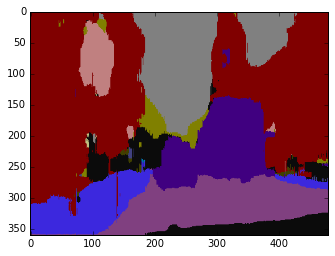

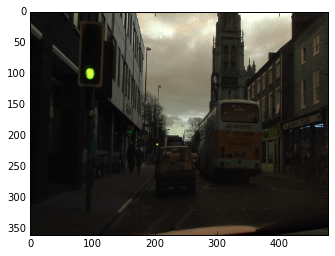

In [17]:
output = autoencoder.predict_proba(train_data[2:3])
pred = visualize(np.argmax(output[0],axis=1).reshape((360,480)), False)
plt.imshow(pred)
plt.figure(2)
plt.imshow(gt[2])